In [1]:
import pandera as pa
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import json

/Users/john_mcclaine/mbit/mbit_venv/lib/python3.10/site-packages/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 22)

In [3]:
data_folder ="../Files/"
geojson_path = f'{data_folder}Distritos_de_Madrid.geojson'

In [4]:
df = pd.read_csv(f'{data_folder}2023_Accidentalidad_c_g_s_d.csv' , sep = ";")

In [5]:
df.head(2)

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,positiva_droga,longitude,latitude,status_code,status_message,api_timestamp,total_results,geohash,road_info,city,country_code,category,type,house_number,postcode,suburb,quarter,road,formatted,confidence,latitude_api,longitude_api,statusCode_speed_api,coordinates_speed_api,road_name_speed_api,speedlimit_speed_api,speedlimit_kph_speed_api,dia_semana,hora_accidente,int_real,ocupacion,vmed
0,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Conductor,De 55 a 59 años,Mujer,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,NaN,-3.667528,40.451898,200,OK,"Mon, 21 Aug 2023 20:31:18 GMT",1,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,Madrid,es,building,building,37,28016.0,Chamartín,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",10,40.452052,-3.667577,200,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,31,50,Sunday,1:15:00,135.100769,5.347692,73.0
1,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Hombre,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,NaN,-3.667528,40.451898,200,OK,"Mon, 21 Aug 2023 20:31:18 GMT",1,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,Madrid,es,building,building,37,28016.0,Chamartín,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",10,40.452052,-3.667577,200,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,31,50,Sunday,1:15:00,135.100769,5.347692,73.0


Abrimos el dataset de Accidentes y unímos con el de Distritos para obtener una descripción del distrito unificado, ya que la del dataset de Accidentes es ligeramente diferente y estaba en mayusculas.
Después se eliminan las columnas redundantes.
Se redondea la velocidad media con dos decimales.
Tambien se le aplica el esquema definido en 2023_Accidentalidad_schema.json.

In [6]:
# Load the schema from the JSON file
with open(f'{data_folder}2023_Accidentalidad_schema.json', 'r') as file:
    schema = json.load(file)

df = (
    pd.read_csv(f'{data_folder}2023_Accidentalidad_c_g_s_d.csv', sep=";", 
                parse_dates=['fecha'])
    .merge(
        (
            gpd.read_file(geojson_path)
            .assign(cod_distrito=lambda x: x['cod_distrito'].astype(int))
            [['cod_distrito', 'NOMBRE']]
        ),
        on='cod_distrito',
        how='left'
    )
    .assign(distrito=lambda x: x['NOMBRE'])  # Assign 'NOMBRE' to a new column 'distrito'
    .drop(columns=["status_code"  , "status_message" , "total_results" , "city" , "country_code" , "suburb" , "confidence" , "api_timestamp" , "statusCode_speed_api" ,  "speedlimit_speed_api"  , "NOMBRE"])  
    .round({'vmed': 2})    
    .astype(schema)
)

Se comprueba que los datos se han tipado

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20526 entries, 0 to 20525
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   num_expediente            20526 non-null  object        
 1   fecha                     20526 non-null  datetime64[ns]
 2   hora                      20526 non-null  object        
 3   localizacion              20526 non-null  object        
 4   numero                    20526 non-null  object        
 5   cod_distrito              20526 non-null  int64         
 6   distrito                  20526 non-null  object        
 7   tipo_accidente            20526 non-null  object        
 8   estado_meteorológico      18215 non-null  object        
 9   tipo_vehiculo             20365 non-null  object        
 10  tipo_persona              20526 non-null  object        
 11  rango_edad                20526 non-null  object        
 12  sexo              

In [8]:
df.head(3)

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,positiva_droga,longitude,latitude,geohash,road_info,category,type,house_number,postcode,quarter,road,formatted,latitude_api,longitude_api,coordinates_speed_api,road_name_speed_api,speedlimit_kph_speed_api,dia_semana,hora_accidente,int_real,ocupacion,vmed
0,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5,Chamartín,Alcance,Despejado,Todo terreno,Conductor,De 55 a 59 años,Mujer,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,NaN,-3.667528,40.451898,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,building,building,37,28016.0,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",40.452052,-3.667577,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,50,Sunday,1:15:00,135.100769,5.347692,73.0
1,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5,Chamartín,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Hombre,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,NaN,-3.667528,40.451898,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,building,building,37,28016.0,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",40.452052,-3.667577,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,50,Sunday,1:15:00,135.100769,5.347692,73.0
2,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5,Chamartín,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Hombre,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,NaN,-3.667528,40.451898,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,building,building,37,28016.0,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",40.452052,-3.667577,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,50,Sunday,1:15:00,135.100769,5.347692,73.0


In [9]:
df.shape

(20526, 40)

Explorar el número de registros:

In [10]:
f'Número total de registros: {df.shape[0]} m número de expedientes únicos: {df.num_expediente.drop_duplicates().shape[0]}'

'Número total de registros: 20526 m número de expedientes únicos: 8682'

Se eliminan los registros en los que la velocidad es 0, ya que tienen impacto en el modelo

In [11]:
df_filter = df[df['speedlimit_kph_speed_api'] > 0].copy()

In [12]:
f'Número total de registros: {df_filter.shape[0]} m número de expedientes únicos: {df_filter.num_expediente.drop_duplicates().shape[0]}'

'Número total de registros: 19349 m número de expedientes únicos: 8159'

Con esta operación se elimina un número de expedientes considerable pero es asumible de cara a conseguir un mejor modelo de predicción para lesividad

In [13]:
f'Porcentaje de registros eliminados: {round(100-((df_filter.shape[0]*100)/df.shape[0]),2)}%'

'Porcentaje de registros eliminados: 5.73%'

In [14]:
f'Porcentaje de expedientes eliminados: {round(100-((df_filter.num_expediente.drop_duplicates().shape[0]*100)/df.num_expediente.drop_duplicates().shape[0]),2)}%'

'Porcentaje de expedientes eliminados: 6.02%'

Se crea una nueva columna que indique si la velocidad de un tramo es superior a 65 kmh

In [15]:
df_filter['high_speed_point'] =  (df_filter['speedlimit_kph_speed_api'] > 65 ).astype(int)

Por último vamos a agrupar las horas por rangos horarios de una hora

In [16]:
df_filter['hora_rango'] = pd.to_datetime(df_filter['hora'], format='%H:%M:%S').dt.hour

In [17]:
accidents_hour = df_filter.groupby('hora_rango')['num_expediente'].count().reset_index()
accidents_hour

,hora_rango,num_expediente
0,0,484
1,1,332
2,2,272
3,3,190
4,4,183
...,...,...
19,19,1328
20,20,1163
21,21,1016
22,22,733


In [18]:
#Distribución de la variable Distrito
valor_umbral1 = 600
valor_umbral2 = 800
valor_umbral3 = 400

In [19]:
#Accidentes_filtrados = Accidentes[Accidentes['distrito'] != 'Despejado']
recuento_distrito = df_filter['distrito'].str.lower().value_counts()

In [20]:
colores = [
    'lightcoral' if recuento < valor_umbral1 else
    'lightblue' if recuento < valor_umbral2 else
    'lightgreen'
    for recuento in recuento_distrito
]

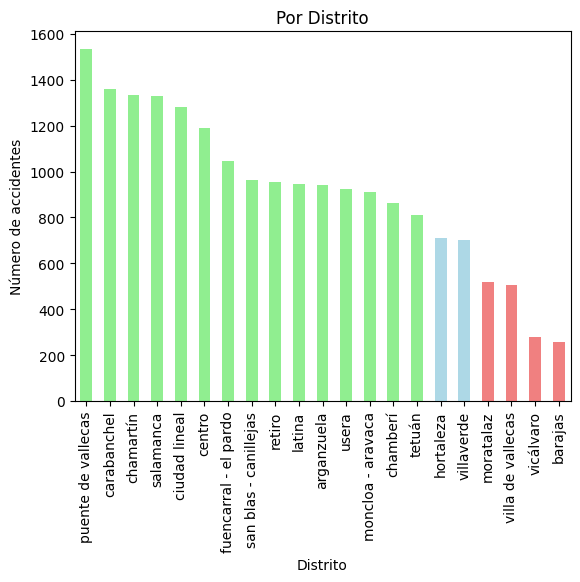

In [21]:
plot = recuento_distrito.plot(kind='bar', title='Por Distrito', color=colores)
plt.ylabel('Número de accidentes')
plt.xlabel('Distrito')
plt.show()

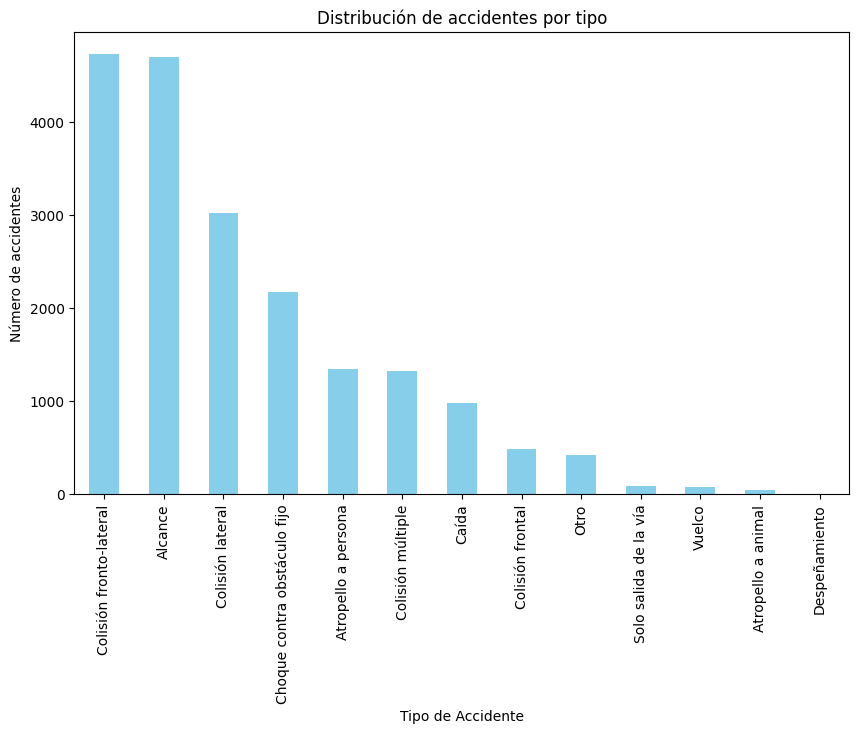

In [22]:
#Distribución de la variable tipo de accidente
accident_counts = df_filter['tipo_accidente'].value_counts()

 

# Create a bar chart
plt.figure(figsize=(10, 6))
accident_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de accidentes por tipo')
plt.xlabel('Tipo de Accidente')
plt.ylabel('Número de accidentes')

 

# Show the bar chart
plt.show()

In [23]:
# Verificamos datos faltantes por columnas
df_filter.isnull().sum() 

num_expediente      0
fecha               0
hora                0
localizacion        0
numero              0
                   ..
int_real            0
ocupacion           0
vmed                0
high_speed_point    0
hora_rango          0
Length: 42, dtype: int64

In [24]:
df_filter.isna().sum().sum() #Sumamos los valores faltantes en su totalidad

55609

In [25]:
#vemos que la columna de positiva_droga tiene casi todos sus valores faltantes
valores_faltantes = df_filter['positiva_droga'].isna().sum()

In [26]:
print(valores_faltantes) #valores faltantes de la columna positiva_droga

19270


In [27]:
len(df_filter['positiva_droga']) #vemos la cantidad de valores totales de la columna positiva_droga

19349

In [28]:
#Vemos el porcentaje total de los valores faltantes
def percentage_missing_data(df):
    missing_data_volume = df.isna().sum().sum() / np.product(df.shape) * 100
    return f'El volumen de los datos faltan es de: {round(missing_data_volume, 2)}%'

In [29]:
percentage_missing_data(df)

'El volumen de los datos faltan es de: 7.26%'

In [30]:
#Graficamos los valores faltantes por columna
def get_accidentes_nan(Accidentes,n):
    Accidentes_nan = (
        Accidentes
        .isna()
        .sum()
        .to_frame()
        .reset_index()
        .rename(columns={'index': 'columnas', 0: 'freq'})
    )
    Accidentes_nan['%'] = round(Accidentes_nan['freq'] / len(Accidentes) * 100, n)
    return Accidentes_nan

In [31]:
Accidentes_nan = get_accidentes_nan(df_filter, 3)

<Axes: ylabel='columnas'>

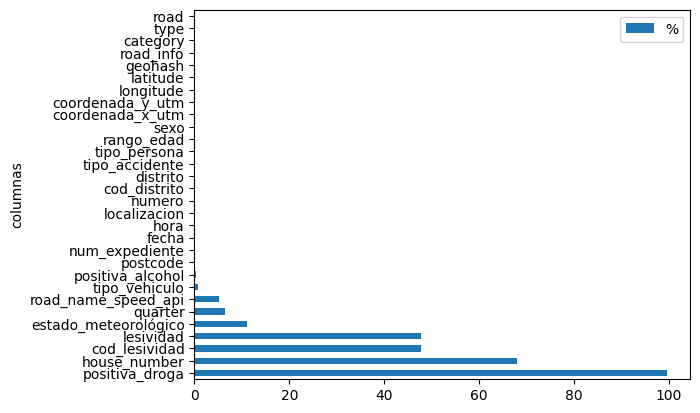

In [32]:
Accidentes_nan.nlargest(30, '%').set_index('columnas')[[ '%']].plot.barh()

In [33]:
#Verificamos la moda de algunas variables catégoricas

In [34]:
moda = df_filter['estado_meteorológico'].mode() #Moda de estado meteorológico

In [35]:
print(moda)

0    Despejado
Name: estado_meteorológico, dtype: object


In [36]:
moda_lesividad = df_filter['lesividad'].mode() #Moda de la variable Lesividad

In [37]:
print(moda_lesividad)

0    Sin asistencia sanitaria
Name: lesividad, dtype: object


In [38]:
moda_tipo_vehiculo = df_filter['tipo_vehiculo'].mode()

In [39]:
print(moda_tipo_vehiculo)

0    Turismo
Name: tipo_vehiculo, dtype: object


In [40]:
#Rellenamos los valores null de la columna positiva droga con ceros

In [41]:
df_filter['positiva_droga'] = df_filter['positiva_droga'].fillna(0).astype(int)

In [42]:
df_filter.head()

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,positiva_droga,longitude,latitude,geohash,road_info,category,type,house_number,postcode,quarter,road,formatted,latitude_api,longitude_api,coordinates_speed_api,road_name_speed_api,speedlimit_kph_speed_api,dia_semana,hora_accidente,int_real,ocupacion,vmed,high_speed_point,hora_rango
0,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5,Chamartín,Alcance,Despejado,Todo terreno,Conductor,De 55 a 59 años,Mujer,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,0,-3.667528,40.451898,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,building,building,37,28016.0,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",40.452052,-3.667577,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,50,Sunday,1:15:00,135.100769,5.347692,73.0,0,1
1,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5,Chamartín,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Hombre,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,0,-3.667528,40.451898,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,building,building,37,28016.0,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",40.452052,-3.667577,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,50,Sunday,1:15:00,135.100769,5.347692,73.0,0,1
2,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5,Chamartín,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Hombre,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,0,-3.667528,40.451898,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,building,building,37,28016.0,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",40.452052,-3.667577,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,50,Sunday,1:15:00,135.100769,5.347692,73.0,0,1
3,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5,Chamartín,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,443397.166,4478129.388,N,0,-3.667528,40.451898,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,building,building,37,28016.0,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",40.452052,-3.667577,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,50,Sunday,1:15:00,135.100769,5.347692,73.0,0,1
4,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5,Chamartín,Alcance,Despejado,Todo terreno,Pasajero,De 55 a 59 años,Hombre,7.0,Asistencia sanitaria sólo en el lugar del acci...,443397.166,4478129.388,N,0,-3.667528,40.451898,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,building,building,37,28016.0,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",40.452052,-3.667577,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,50,Sunday,1:15:00,135.100769,5.347692,73.0,0,1


In [43]:
#Vemos cuantos valores faltantes tenemos luego de rellenar la columna de positiva_droga
df_filter.isna().sum().sum() 

36339

In [44]:
#Vemos el porcentaje de valores faltantes luego de rellenar la columna de positiva_droga
def percentage_missing_data(df):
    missing_data_volume = df.isna().sum().sum() / np.product(df.shape) * 100
    return f'El volumen de los datos faltan es de: {round(missing_data_volume, 2)}%'

In [45]:
percentage_missing_data(df_filter)

'El volumen de los datos faltan es de: 4.47%'

In [46]:
#Graficamos los valores faltantes por columna luego de rellenar la columna de positiva_droga
def get_accidentes_nan(Accidentes,n):
    Accidentes_nan = (
        Accidentes
        .isna()
        .sum()
        .to_frame()
        .reset_index()
        .rename(columns={'index': 'columnas', 0: 'freq'})
    )
    Accidentes_nan['%'] = round(Accidentes_nan['freq'] / len(Accidentes) * 100, n)
    return Accidentes_nan

In [47]:
Accidentes_nan = get_accidentes_nan(df_filter, 3)

<Axes: ylabel='columnas'>

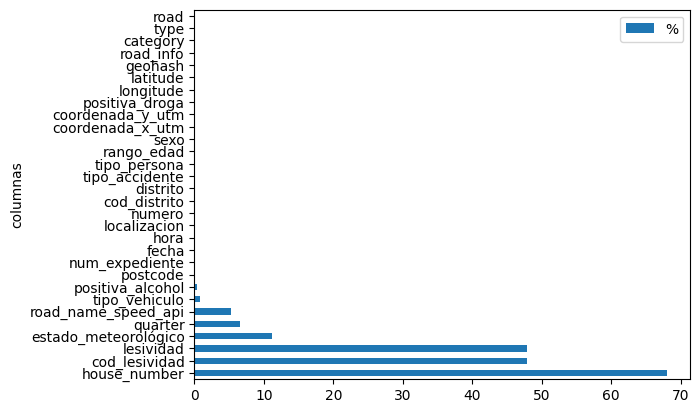

In [48]:
Accidentes_nan.nlargest(30, '%').set_index('columnas')[[ '%']].plot.barh()

In [49]:
#Reemplazamos los valores faltantes por su moda ya que son variables categóricas

In [50]:
# Lista de columnas categóricas
categorical_columns = ['tipo_vehiculo', 'numero', 'estado_meteorológico', 'cod_lesividad', 'lesividad', 
                       'positiva_alcohol', 
                      'rango_edad', 'sexo']

In [51]:
def fill_missing_with_mode(Accidentes_nuevo, categorical_columns):
    for column in categorical_columns:
        moda = Accidentes_nuevo[column].mode()[0]
        Accidentes_nuevo[column].fillna(moda, inplace=True)
        

In [52]:
fill_missing_with_mode(df_filter, categorical_columns)

In [53]:
df_filter.isna().sum()

num_expediente      0
fecha               0
hora                0
localizacion        0
numero              0
                   ..
int_real            0
ocupacion           0
vmed                0
high_speed_point    0
hora_rango          0
Length: 42, dtype: int64

In [54]:
df_filter.shape

(19349, 42)

Guardamos el dataset. Esta columna queda comentada para evitar alterar el dataset

In [55]:
#df_filter.to_csv(f'{data_folder}2023_Accidentalidad_c_g_s_d_clean.csv' , sep = ";")

In [56]:
#Sección de Análisis extra con el dataset completo con Apis y limpio

In [57]:
df_Acc = pd.read_csv(f'{data_folder}2023_Accidentalidad_c_g_s_d_clean.csv' , sep = ";")

In [58]:
#Analisis extras con el dataset de accidentalidad completo con más varibales
#c = coordinates 
#g = geolocation API applied
#s = speed api applied
#d = density added

In [59]:
#Vemos las 15 calles donde más accidentes hay
top15_accidentes = df_Acc.drop_duplicates(subset='num_expediente').groupby('road_name_speed_api').size().nlargest(15)

In [60]:
top15_accidentes

road_name_speed_api
M-30                                     258
Paseo de la Castellana                   162
Calle de Alcalá                          133
Calle 30                                 123
Avenida de los Poblados                   90
Calle del Príncipe de Vergara             66
Calle de Arturo Soria                     61
Calle de Bravo Murillo                    58
Avenida de Andalucía                      53
Avenida de la Albufera                    53
Calle Gran Vía                            42
Calle de O'Donnell                        41
Calle de los Hermanos García Noblejas     39
A-42                                      38
Calle Doctor Esquerdo                     38
dtype: int64

In [61]:
#Graficamos las 15 calles donde más accidentes hay
df_top15_accidentes = pd.DataFrame(top15_accidentes, columns=['Cantidad de Accidentes'])

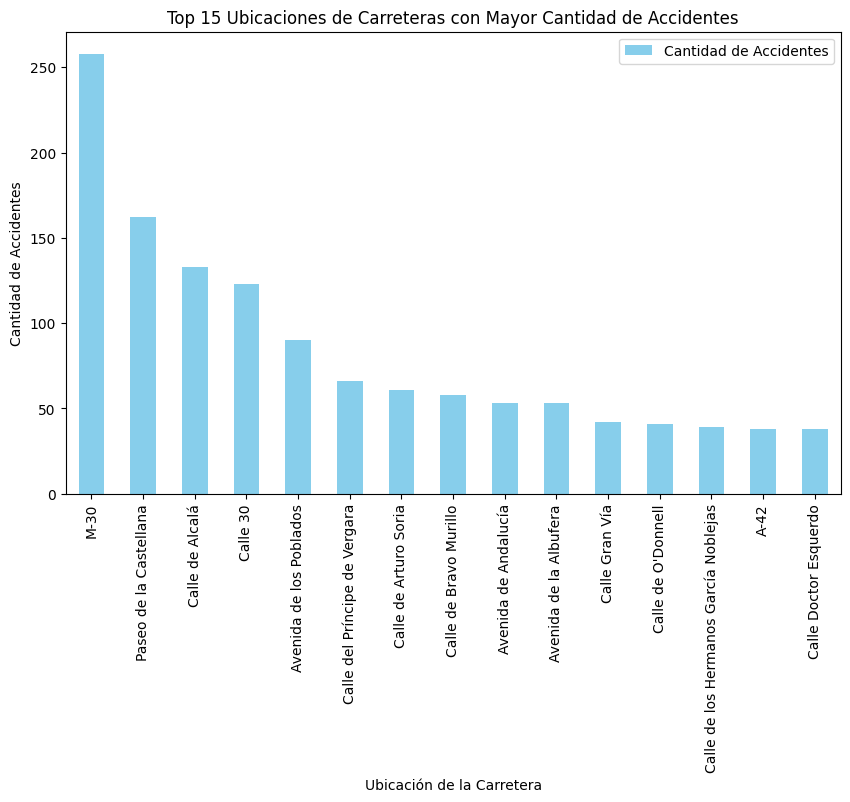

In [62]:
df_top15_accidentes.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 15 Ubicaciones de Carreteras con Mayor Cantidad de Accidentes')
plt.xlabel('Ubicación de la Carretera')
plt.ylabel('Cantidad de Accidentes')
plt.show()

In [63]:
df_Acc.head()

,Unnamed: 0,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,cod_lesividad,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,positiva_droga,longitude,latitude,geohash,road_info,category,type,house_number,postcode,quarter,road,formatted,latitude_api,longitude_api,coordinates_speed_api,road_name_speed_api,speedlimit_kph_speed_api,dia_semana,hora_accidente,int_real,ocupacion,vmed,high_speed_point,hora_rango
0,0,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5,Chamartín,Alcance,Despejado,Todo terreno,Conductor,De 55 a 59 años,Mujer,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,0,-3.667528,40.451898,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,building,building,37,28016.0,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",40.452052,-3.667577,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,50,Sunday,1:15:00,135.100769,5.347692,73.0,0,1
1,1,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5,Chamartín,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Hombre,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,0,-3.667528,40.451898,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,building,building,37,28016.0,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",40.452052,-3.667577,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,50,Sunday,1:15:00,135.100769,5.347692,73.0,0,1
2,2,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5,Chamartín,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Hombre,14.0,Sin asistencia sanitaria,443397.166,4478129.388,N,0,-3.667528,40.451898,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,building,building,37,28016.0,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",40.452052,-3.667577,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,50,Sunday,1:15:00,135.100769,5.347692,73.0,0,1
3,3,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5,Chamartín,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Mujer,7.0,Asistencia sanitaria sólo en el lugar del acci...,443397.166,4478129.388,N,0,-3.667528,40.451898,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,building,building,37,28016.0,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",40.452052,-3.667577,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,50,Sunday,1:15:00,135.100769,5.347692,73.0,0,1
4,4,2023S000001,2023-01-01,01:15:00,"AVDA. ALFONSO XIII, 33",33,5,Chamartín,Alcance,Despejado,Todo terreno,Pasajero,De 55 a 59 años,Hombre,7.0,Asistencia sanitaria sólo en el lugar del acci...,443397.166,4478129.388,N,0,-3.667528,40.451898,ezjqhs1672bpxkbcncp1,Avenida de Alfonso XIII,building,building,37,28016.0,Ciudad Jardín,Avenida de Alfonso XIII,"Avenida de Alfonso XIII, 37, 28016 Madrid, Spain",40.452052,-3.667577,"{'latitude': 40.45191182917747, 'longitude': -...",Avenida de Alfonso XIII,50,Sunday,1:15:00,135.100769,5.347692,73.0,0,1


In [64]:
top15_victimas = df_Acc.groupby('road_name_speed_api').size().nlargest(15)

In [65]:
top15_victimas

road_name_speed_api
M-30                             681
Paseo de la Castellana           376
Calle 30                         340
Calle de Alcalá                  340
Avenida de los Poblados          240
Calle de Arturo Soria            166
Calle del Príncipe de Vergara    153
Avenida de Andalucía             145
Avenida de la Albufera           141
Calle de Bravo Murillo           125
Calle de O'Donnell               106
Calle Gran Vía                    99
A-42                              98
Calle de Francisco Silvela        98
Calle de María de Molina          98
dtype: int64

In [66]:
df_top15_victimas = pd.DataFrame(top15_victimas, columns=['Cantidad de Accidentes'])

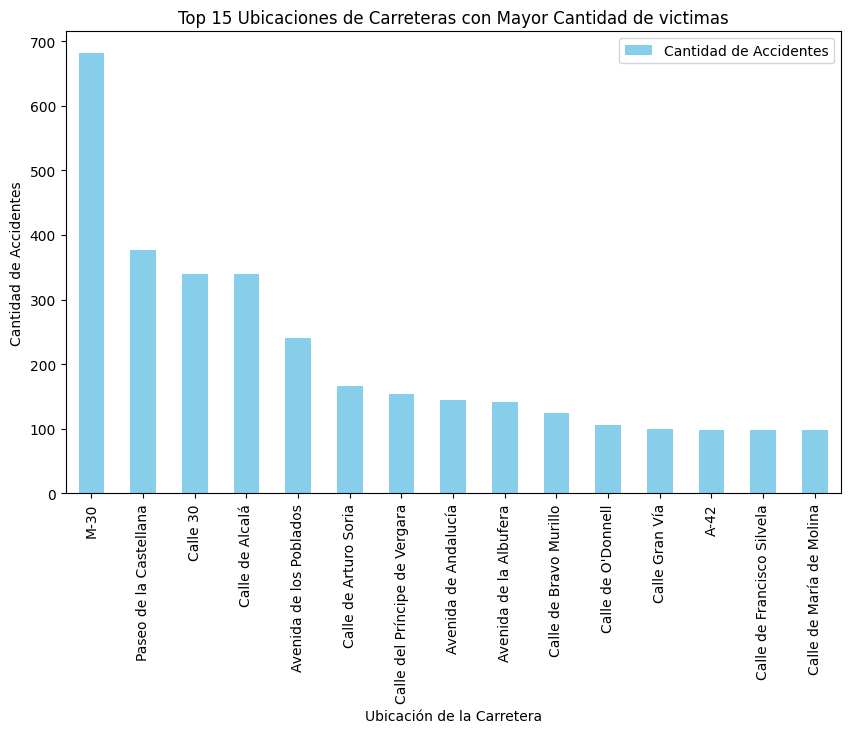

In [67]:
df_top15_victimas.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Top 15 Ubicaciones de Carreteras con Mayor Cantidad de victimas')
plt.xlabel('Ubicación de la Carretera')
plt.ylabel('Cantidad de Accidentes')
plt.show()